## Coupling Fit for 200 GeV AuAu Collision at RHIC

In [1]:
import os
import sys
#import hic
#import utilities
import pandas as pd
import numpy as np
import xarray as xr
#import plasma
#import plasma_interaction as pi
#import jets
#import config
import matplotlib.pyplot as plt
# import scipy.stats as stats
import scipy.interpolate as interpolate
from scipy.special import expi
import numpy.random as rn
import scipy.optimize as optimize
import fnmatch
# from scipy import integrate
# from scipy.interpolate import RegularGridInterpolator
# from scipy.special import expi
# import fnmatch
#import lhapdf

%matplotlib inline

# Set up TeX
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

# Set Fit Parameters

In [8]:
cent_choice = '30-40'
cel_bool = True

if cel_bool:
    coupling_list = np.array([1.6, 1.9])#, 2.2])
else:
    coupling_list = np.array([2.0, 2.3])#, 2.6])


# Set fit bounds
pt_min = 5
pt_max = 8

# Load Data

In [4]:
# Load fluctuating initial condition observables

obs = {}
tag_list = ['f_100', 'f_100_cel']
# ['p_100', 'p_100_cel', 'p_125', 'p_125_cel', 'p_075', 'p_075_cel', 'p_000', 'p_000_cel', 
#  'f_100', 'f_100_cel', 'f_125', 'f_125_cel', 'f_075', 'f_075_cel', 'f_000', 'f_000_cel', 
#  'c_100', 'c_100_cel', 'c_125', 'c_125_cel', 'c_075', 'c_075_cel', 'c_000', 'c_000_cel']

obs_0 = {}
# fluct_dir = '/fs1/project/sievert_nt/ape_data/drift_letter/v0.10.0/g2.1-g1.7/observables/'
fluct_dir = '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.0_g_rad=2.0_g_col=1.6/observables/'

for tag in tag_list:
    print(f"Loading {tag} Files")
    obs_0[tag] = xr.open_dataset(fluct_dir + tag + ".nc")
    if "cel" in tag:
        for variable in obs_0[tag].data_vars:
            obs_0[tag][variable].attrs['g'] = 1.6
    else:
        for variable in obs_0[tag].data_vars:
            obs_0[tag][variable].attrs['g'] = 2.0

obs_1 = {}
fluct_dir = '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.3_g_col=1.9/observables/'
for tag in tag_list:
    print(f"Loading {tag} Files")
    obs_1[tag] = xr.open_dataset(fluct_dir + tag + ".nc")
    if "cel" in tag:
        for variable in obs_1[tag].data_vars:
            obs_1[tag][variable].attrs['g'] = 1.9
    else:
        for variable in obs_1[tag].data_vars:
            obs_1[tag][variable].attrs['g'] = 2.3

obs_2 = {}
fluct_dir = '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.6_g_col=2.2/observables/'
for tag in tag_list:
    print(f"Loading {tag} Files")
    obs_2[tag] = xr.open_dataset(fluct_dir + tag + ".nc")
    if "cel" in tag:
        for variable in obs_2[tag].data_vars:
            obs_2[tag][variable].attrs['g'] = 2.2
    else:
        for variable in obs_2[tag].data_vars:
            obs_2[tag][variable].attrs['g'] = 2.6

for tag in tag_list:
    obs[tag] = xr.merge([obs_0[tag], obs_1[tag], obs_2[tag]])  



    

Loading f_100 Files
Loading f_100_cel Files
Loading f_100 Files
Loading f_100_cel Files
Loading f_100 Files


PermissionError: [Errno 13] Permission denied: '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.6_g_col=2.2/observables/f_100.nc'

In [ ]:
obs["f_100"]

# Load Exp. Data

In [ ]:
######################################
# Load pp pion yield from ALICE data #
######################################

# File path for data files
pp_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_2.csv'
# PbPb_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_1.csv'
# RAA_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_15.csv'
# RAA_file_path = '/fs1/project/sievert_nt/ape_data/hasan/HEPData-ins625472-v1-Figure_12a.csv'
# CMS_mb_file_path = '/fs1/project/sievert_nt/exp_data/LHC_PbPb_5.02TeV_RAA_HEPData-ins1496050-v2-csv/Table15.csv'
# CMS_30_50_file_path = '/fs1/project/sievert_nt/exp_data/LHC_PbPb_5.02TeV_RAA_HEPData-ins1496050-v2-csv/Table11.csv'

cent_bins = np.array(['0-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90'])
RAA_cent_bins = np.array(['0-5', '5-10', '10-20', '20-40', '40-60', '60-80','20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])


# Load cross-section data for interpolation
pp_data = pd.read_table(pp_file_path, header=None, delimiter=',', dtype=np.float64,
                            names=['pt', 'bin_edge_0', 'bin_edge_1', 'dN', 'stat+', 'stat-', 'syst+', 'syst-'], skiprows=12)
dNpp = interpolate.interp1d(pp_data['pt'], pp_data['dN'], bounds_error=False, fill_value='extrapolate')

# PbPb_data = pd.DataFrame({})
# i = 0
# for cent in cent_bins:
#     # Read relevant centrality section
#     PbPb_data_cent = pd.read_table(PbPb_file_path, header=None, delimiter=',', dtype=np.float64,
#                             names=['pt', 'bin_edge_0', 'bin_edge_1', 'dN', 'stat+', 'stat-', 'syst+', 'syst-', 'uncsyst+', 'uncsyst-'],
#                                    skiprows=13+(i*64), nrows=58)
    
#     # Make centrality series
#     PbPb_data_cent['cent'] = np.full_like(PbPb_data_cent['pt'].to_numpy(), cent, dtype=object)
    
#     # Append to dataframes
#     PbPb_data = pd.concat([PbPb_data, PbPb_data_cent])
    
#     i += 1

# RAA_data = pd.DataFrame({})
# i = 0
# for cent in RAA_cent_bins:
#     # Read relevant centrality section
#     RAA_data_cent = pd.read_table(RAA_file_path, header=None, delimiter=',', dtype=np.float64,
#                             names=['pt', 'bin_edge_0', 'bin_edge_1', 'RAA', 'stat+', 'stat-', 'syst+', 'syst-'],
#                                    skiprows=14+(i*65), nrows=58)
    
#     # Make centrality series
#     RAA_data_cent['cent'] = np.full_like(RAA_data_cent['pt'].to_numpy(), cent, dtype=object)
    
#     # Append to dataframes
#     RAA_data = pd.concat([RAA_data, RAA_data_cent])
    
#     i += 1
#     # PbPb_data = pd.read_table(pp_file_path, header=None, delimiter=',', dtype=np.float64,
#     #                         names=['pt', 'bin_edge_0', 'bin_edge_1', 'dN', 'stat+', 'stat-', 'syst+', 'syst-'], skiprows=12)

# CMS_mb_data = pd.read_table(CMS_mb_file_path, header=None, delimiter=',', dtype=np.float64,
#                         names=['pt', 'bin_edge_0', 'bin_edge_1', 'RAA', 'stat+', 'stat-', 'syst+', 'syst-', 
#                                "sys,TAA +","sys,TAA -","sys,lumi +","sys,lumi -"],
#                                skiprows=14)
# CMS_30_50_data = pd.read_table(CMS_30_50_file_path, header=None, delimiter=',', dtype=np.float64,   
#                         names=['pt', 'bin_edge_0', 'bin_edge_1', 'RAA', 'stat+', 'stat-', 'syst+', 'syst-', 
#                                "sys,TAA +","sys,TAA -","sys,lumi +","sys,lumi -"],
#                                skiprows=14) #that's all I need

# if cent_choice == '0-100':
#     p_err = np.sqrt((CMS_mb_data['stat+']**2 + CMS_mb_data['syst+']**2 + CMS_mb_data["sys,TAA +"]**2 + CMS_mb_data["sys,lumi +"]**2).to_numpy())
#     n_err = np.sqrt((CMS_mb_data['stat-']**2 + CMS_mb_data['syst-']**2 + CMS_mb_data["sys,TAA -"]**2 + CMS_mb_data["sys,lumi -"]**2).to_numpy())
#     CMS_raa_pt_array = CMS_mb_data['pt'].to_numpy()
#     CMS_pt_bins = np.append(CMS_mb_data['bin_edge_0'].to_numpy()[0:-1], CMS_mb_data['bin_edge_1'].to_numpy()[-1])
#     CMS_raa_RAA_array = CMS_mb_data['RAA'].to_numpy()
# elif cent_choice == '30-50':
#     p_err = np.sqrt((CMS_30_50_data['stat+']**2 + CMS_30_50_data['syst+']**2 + CMS_30_50_data["sys,TAA +"]**2 + CMS_30_50_data["sys,lumi +"]**2).to_numpy())
#     n_err = np.sqrt((CMS_30_50_data['stat-']**2 + CMS_30_50_data['syst-']**2 + CMS_30_50_data["sys,TAA -"]**2 + CMS_30_50_data["sys,lumi -"]**2).to_numpy())
#     CMS_raa_pt_array = CMS_30_50_data['pt'].to_numpy()
#     CMS_pt_bins = np.append(CMS_30_50_data['bin_edge_0'].to_numpy()[0:-1], CMS_30_50_data['bin_edge_1'].to_numpy()[-1])
#     CMS_raa_RAA_array = CMS_30_50_data['RAA'].to_numpy()
# # elif cent_choice == '30-50_log':
# #     p_err = (CMS_30_50_data['stat+'] + CMS_30_50_data['syst+'] + CMS_30_50_data["sys,TAA +"] + CMS_30_50_data["sys,lumi +"]).to_numpy()
# #     n_err = (CMS_30_50_data['stat-'] + CMS_30_50_data['syst-'] + CMS_30_50_data["sys,TAA -"] + CMS_30_50_data["sys,lumi -"]).to_numpy()
# #     CMS_raa_pt_array = CMS_30_50_data['pt'].to_numpy()
# #     CMS_raa_RAA_array = CMS_30_50_data['RAA'].to_numpy()


# fig, axis = plt.subplots()
# axis.set_xlabel(r'$p_T$')
# axis.set_ylabel(r'$R_{AA}$')
# axis.set_title(r'FF Pions')
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# i = 0
# for cent in ['0-5', '30-40', '60-70']:  #cent_bins:
#     # Make centrality cut
#     # p_mask = (partons['el'] == True) & (partons['drift'] == True) & (partons['fg'] == False) & (partons['cent'] == cent)

#     # # Bin pions
#     # pion_counts_pp, pion_bins_pp = np.histogram(partons[p_mask]['pion_pt'], weights=partons[p_mask]['weight'], bins=200)
#     # #pion_counts_pA, pion_bins_pA = np.histogram(partons[p_mask]['pion_pt'], weights=partons[p_mask]['pA_weight'], bins=pion_bins_pp)
#     # pion_counts_AA, pion_bins_AA = np.histogram(partons[p_mask]['pion_pt_f'], weights=partons[p_mask]['pA_weight'], bins=pion_bins_pp)

#     # # Compute R_AA
#     # pion_aa_pp = pion_counts_AA / pion_counts_pp

#     # Get ALICE R_AA
#     alice_raa_pt_array = RAA_data[RAA_data['cent'] == cent]['pt'].to_numpy()
#     alice_raa_RAA_array = RAA_data[RAA_data['cent'] == cent]['RAA'].to_numpy()

#     # Plot
#     # axis.plot(pion_bins_pp[0:-1], pion_aa_pp, label='JMA {}%'.format(cent), color=colors[i])
#     axis.plot(alice_raa_pt_array, alice_raa_RAA_array, label='ALICE {}%'.format(cent), linestyle='--', color=colors[i])
#     i += 1


# axis.plot(CMS_raa_pt_array, CMS_raa_RAA_array, label='CMS {}%'.format(cent_choice), color=colors[i])  #, linestyle='--'

# axis.legend()
# axis.set_xlim(0, 50)

# #np.savetxt('data_alice.csv', np.stack((alice_raa_pt_array, alice_raa_RAA_array), axis=-1))

In [ ]:
# ######################################
# # Load AA yield from PHENIX data #
# ######################################

# # File path for data files
# pp_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_2.csv'
# # PbPb_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_1.csv'
# # RAA_file_path = '/fs1/project/sievert_nt/exp_data/ALICE_data/HEPData-ins1759506-v1-Table_15.csv'
# RAA_file_path = '/fs1/project/sievert_nt/ape_data/hasan/HEPData-ins625472-v1-Figure_12a.csv'
# # CMS_mb_file_path = '/fs1/project/sievert_nt/exp_data/LHC_PbPb_5.02TeV_RAA_HEPData-ins1496050-v2-csv/Table15.csv'
# # CMS_30_50_file_path = '/fs1/project/sievert_nt/exp_data/LHC_PbPb_5.02TeV_RAA_HEPData-ins1496050-v2-csv/Table11.csv'
file_path = "/fs1/project/sievert_nt/exp_data/RHIC_AuAu_200GeV_HEPData-ins625472-v1-csv/HEPData-ins625472-v1-Figure_12a.csv"

In [ ]:
# Load all data from a file
data = {}
data_cents = ['mb', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70']  # look for headers of each table
table_starts = [8, 42, 76, 110, 144, 178, 212, 246]  # Rows at which table starts -- w/ header, ZERO INDEXED!!!
for i in np.arange(0, len(data_cents)):
    cent = data_cents[i]
    start = table_starts[i]
    data[cent] = pd.read_csv(file_path, skiprows=start, nrows=31)


In [ ]:
data['30-40'].columns

In [ ]:
import matplotlib.pyplot as plt

# Select dataframe (centrality bin)
df = data['30-40']

# Get columns
xdata = df['$p_{T}$ (GeV/$c$)'].to_numpy()
ydata = df['$R_{AA}$'].to_numpy()
p_err_data_list = ['stat. +', 'sys. (bounds) +']
n_err_data_list = ['stat. -', 'sys. (bounds) -']

# Add all errors in quadrature
p_y_err = np.zeros_like(ydata)
for tag in p_err_data_list:
    p_y_err = p_y_err + df[tag].to_numpy()**2
p_y_err = np.sqrt(p_y_err)

n_y_err = np.zeros_like(ydata)
for tag in n_err_data_list:
    n_y_err = n_y_err + df[tag].to_numpy()**2
n_y_err = np.sqrt(n_y_err)
    
# Plot
fig, axis = plt.subplots()
axis.set_xlabel(r'$p_T$', size = 14)
axis.set_ylabel(r'$R_{AA}$', size = 14)
axis.errorbar(xdata, ydata, yerr=[n_y_err, p_y_err])

# Compute $R_{AA}$ (APE)

In [ ]:
import os
import sys
#import hic
#import utilities
import pandas as pd
import numpy as np
import xarray as xr
#import plasma
#import plasma_interaction as pi
#import jets
#import config
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.interpolate as interpolate
import numpy.random as rn
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator
from scipy.special import expi


import scipy.optimize as optimize
import fnmatch
# import lhapdf

%matplotlib inline
%config InlineBackend.figure_format='png'
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'Helvetica'

# Calculate $p_T$ spectrum and R_AA

In [5]:
# Add these to partons!



# old_p_cols = ['process', 'pt_0', 'pt_f', 'weight', 'ncoll', 'mult', 'z', 'pp_z', 'el', 'drift', 'fg', 'cel',
#           'phi_0', 'phi_f', 'psi_2', 'v_2', 'id', 'q_el', 'q_drift', 'e2',
#           'Tmax_event', 'b', 'rmax', 'time_total_plasma', 'jetNo', 'x_0', 'process_run', 'seed', 'fgqhat', 
#           'q_fg_utau_qhat',  'q_fg_uperp_qhat', 'Tavg_qgp_parton', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
#           'npart']

# For general things
# p_cols = ['process', 'pt_0', 'pt_f', 'weight', 'ncoll', 'mult', 'z', 'pp_z', 'el', 'drift', 'fg', 'cel',
#           'phi_0', 'phi_f', 'psi_2', 'v_2', 'id', 'q_el', 'q_drift', 'e2', 'AA_weight', 'hadron_pt_0', 'hadron_pt_f',
#           'Tmax_event', 'b', 'rmax', 'time_total_plasma', 'partonNo', 'x_0', 'y_0', 'process_run', 'seed', 'fgqhat', 
#           'q_fg_utau_qhat',  'q_fg_uperp_qhat', 'Tavg_qgp_parton', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
#           'urqmd_re_q_3', 'urqmd_im_q_3', 'urqmd_re_q_4', 'urqmd_im_q_4', 'npart', 'K_F_DRIFT']

# For v_n
# p_cols = ['pt_f', 'mult', 'drift', 'cel', 'seed', 'pt_0', 'e2', 'e3', 'e4', 'psi_e2', 'psi_e3', 'psi_e4', 'weight',
#           'phi_0', 'phi_f', 'psi_2', 'AA_weight', 'hadron_pt_0', 'hadron_pt_f', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
#           'urqmd_re_q_3', 'urqmd_im_q_3', 'urqmd_re_q_4', 'urqmd_im_q_4', 'K_F_DRIFT']
#p_cols = ['seed', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N']
# p_cols = ['pt_f', 'mult', 'drift', 'cel', 'seed', 'pt_0', 'e2', 'e3', 'e4', 'psi_e2', 'psi_e3', 'psi_e4', 'weight',
#           'phi_0', 'phi_f', 'psi_2', 'AA_weight', 'hadron_pt_0', 'hadron_pt_f', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
#           'urqmd_re_q_3', 'urqmd_im_q_3', 'urqmd_re_q_4', 'urqmd_im_q_4', 'K_F_DRIFT', 'Tmax_event', 'process', 'process_run']
#p_cols = ['weight', 'el', 'mult', 'process', 'K_F_DRIFT', 'process_run', 'drift', 'cel', 'phi_0', 'pt_0', 'id', 'phi_f', 'pt_f', 'hadron_pt_0', 'hadron_pt_f', 'AA_weight', 'psi_2']#'b', 'weight', 'mult', 'psi_e2']
#p_cols = ['weight', 'process', 'process_run', 'seed', 'K_F_DRIFT', 'drift', 'cel', 'pt_f', 'pt_0', 'phi_0', 'phi_f']#['pt_f', 'pt_0', 'phi_0', 'phi_f', 'AA_weight', 'mult', 'drift', 'cel']

p_cols = ['mult', 'pt_0', 'pt_f', 'hadron_pt_0', 'hadron_pt_f', 'weight', 'AA_weight', 'cel','g']

partons = pd.DataFrame({})
# all = ['jetNo', 'tag', 'weight', 'id', 'pt', 'pt_f', 'q_el', 'q_drift',
#        'q_drift_abs', 'q_grad', 'q_grad_abs', 'q_fg', 'q_fg_abs',
#        'extinguished', 'x0', 'y0', 'phi_0', 'phi_f', 't_qgp', 't_hrg',
#        't_unhydro', 'time_total_plasma', 'time_total_hrg',
#        'time_total_unhydro', 'Tmax_jet', 'initial_time', 'final_time', 'tau',
#        'Tmax_event', 'drift', 'grad', 'el', 'fg', 'exit', 'process', 'b',
#        'npart', 'ncoll', 'mult', 'e2_re', 'e2_im', 'psi_e2', 'e3_re', 'e3_im',
#        'psi_e3', 'e4_re', 'e4_im', 'psi_e4', 'e5_re', 'e5_im', 'psi_e5',
#        'seed', 'rmax', 'e2', 'e3', 'e4', 'e5', 'q_2_re', 'q_2_im', 'psi_2',
#        'q_3_re', 'q_3_im', 'psi_3', 'v_2', 'v_3', 'z', 'pp_z', 'pion_pt']

# dir_list = np.array(['/fs1/project/sievert_nt/jma_data/raa-v2/g2.0_cel',
#                      '/fs1/project/sievert_nt/jma_data/raa-v2/lanl05_set_0',
#                      '/fs1/project/sievert_nt/jma_data/raa-v2/lanl05_set_1',
#                      '/fs1/project/sievert_nt/jma_data/raa-v2/lanl05_set_2',
#                      '/fs1/project/sievert_nt/jma_data/raa-v2/lanl05_set_3',
#                      '/fs1/project/sievert_nt/jma_data/raa-v2/lanl05_set_4'])
#dir_list = np.array(['/fs1/project/sievert_nt/ape_data/drift_letter/2024.08.03'])
dir_list = np.array(['/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.0_g_rad=2.0_g_col=1.6', '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.3_g_col=1.9', '/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.6_g_col=2.2'])
# dir_list2 = np.array(['/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.3_g_col=1.9'])
# dir_list3 = np.array(['/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.6_g_col=2.2'])
#dir_list = np.array(['/mnt/c/Users/Jo/Desktop/2024.08.03_partons'])

#dataset1
for i in np.arange(0, len(dir_list)):
    dir =  str(dir_list[i])
    data_files = np.array(os.listdir(dir))
    p_files = fnmatch.filter(data_files, '*partons*.parquet')
    
    print(dir)
    
    #load_events = 100000
    print('{} parton files'.format(len(p_files)))
    
    # k=0
    # try:
    #     if k < len(p_files):
    #         loaded_df = pd.read_parquet(dir + '/' + p_files[k])
    #         #loaded_df = reduce_mem_usage(loaded_df)
    #         print('Available columns:')
    #         print(loaded_df.columns.to_numpy())
            
    # except ValueError:
    #     print('empty file')
    #     k += 1
    
    i = 0
    try:
        for file in p_files:
            print('loading files ... {}%'.format(i*100/len(p_files)))
            try:
                loaded_df = pd.read_parquet(dir + '/' + file, columns=p_cols)
                #loaded_df = reduce_mem_usage(loaded_df)
                partons = pd.concat([partons, loaded_df], axis=0)
            except ValueError:
                print('empty file')
            try:
                loaded_events = int(len(partons['seed'].value_counts()))
                print('Loaded ~{} events'.format(loaded_events))
                # if loaded_events > load_events:
                #     break
            except:
                pass
            i += 1
    except Exception as error:
        # handle the exception
        print("An exception occurred:", type(error).__name__, "–", error)
    print('Loaded {} files'.format(i))
    #print('{}% loaded'.format(i*100/len(p_files)))

# #dataset2
# for i in np.arange(0, len(dir_list2)):
#     dir =  str(dir_list2[i])
#     data_files2 = np.array(os.listdir(dir))
#     p_files = fnmatch.filter(data_files2, '*partons*.parquet')
    
#     print(dir)
        
#     i = 0
#     try:
#         for file in p_files:
#             print('loading files ... {}%'.format(i*100/len(p_files)))
#             try:
#                 loaded_df = pd.read_parquet(dir + '/' + file, columns=p_cols)
#                 #loaded_df = reduce_mem_usage(loaded_df)
#                 partons = pd.concat([partons, loaded_df], axis=0)
#             except ValueError:
#                 print('empty file')
#             try:
#                 loaded_events = int(len(partons['seed'].value_counts()))
#                 print('Loaded ~{} events'.format(loaded_events))
#                 # if loaded_events > load_events:
#                 #     break
#             except:
#                 pass
#             i += 1
#     except Exception as error:
#         # handle the exception
#         print("An exception occurred:", type(error).__name__, "–", error)
#     print('Loaded {} files'.format(i))
#     #print('{}% loaded'.format(i*100/len(p_files)))

# #dataset3
# for i in np.arange(0, len(dir_list3)):
#     dir =  str(dir_list3[i])
#     data_files3 = np.array(os.listdir(dir))
#     p_files = fnmatch.filter(data_files3, '*partons*.parquet')
    
#     print(dir)
        
#     i = 0
#     try:
#         for file in p_files:
#             print('loading files ... {}%'.format(i*100/len(p_files)))
#             try:
#                 loaded_df = pd.read_parquet(dir + '/' + file, columns=p_cols)
#                 #loaded_df = reduce_mem_usage(loaded_df)
#                 partons3 = pd.concat([partons, loaded_df], axis=0)
#             except ValueError:
#                 print('empty file')
#             try:
#                 loaded_events = int(len(partons['seed'].value_counts()))
#                 print('Loaded ~{} events'.format(loaded_events))
#                 # if loaded_events > load_events:
#                 #     break
#             except:
#                 pass
#             i += 1
#     except Exception as error:
#         # handle the exception
#         print("An exception occurred:", type(error).__name__, "–", error)
#     print('Loaded {} files'.format(i))
#     #print('{}% loaded'.format(i*100/len(p_files)))

/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.0_g_rad=2.0_g_col=1.6
13 parton files
loading files ... 0.0%
loading files ... 7.6923076923076925%
loading files ... 15.384615384615385%
loading files ... 23.076923076923077%
loading files ... 30.76923076923077%
loading files ... 38.46153846153846%
loading files ... 46.15384615384615%
loading files ... 53.84615384615385%
loading files ... 61.53846153846154%
loading files ... 69.23076923076923%
loading files ... 76.92307692307692%
loading files ... 84.61538461538461%
loading files ... 92.3076923076923%
Loaded 13 files
/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_rad=2.3_g_col=1.9
10 parton files
loading files ... 0.0%
loading files ... 10.0%
loading files ... 20.0%
loading files ... 30.0%
loading files ... 40.0%
loading files ... 50.0%
loading files ... 60.0%
loading files ... 70.0%
loading files ... 80.0%
loading files ... 90.0%
Loaded 10 files
/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.1_g_

In [6]:
######################
# Centrality Binning #
######################
'''
Binning the data according to multiplicity bins to mimic experimental "centrality".
'''
# print('Plotting multiplicity distribution')
# fig, axis = plt.subplots()
# axis.set_xlabel(r'$mult.$')
# axis.set_ylabel(r'$N$')#, rotation=0)
# df = partons

# avg_array = np.array([])
# for seed in df['seed'].value_counts().index.to_numpy():
#     # bin data
#     mask = (df['seed'] == seed)

#     # average
#     avg = np.mean(df[mask]['mult'])
#     avg_array = np.append(avg_array, avg)

# axis.hist(avg_array, bins=250)#, marker='+')

# axis.legend()
#avg_array = np.load('mult_list.npz')['arr_0.npy']


    #0603010


print('Binning by centrality')
# Bin by centrality using percentile bounds on multiplicity
# Create percentile bounds using partonic data
# -- partonic data should have constant number of entries per event, so
# -- no need for craziness
# Apply label series to each entry
cent_bins = np.array(['90-100', '80-90', '70-80', '60-70', '50-60', '40-50',
                      '30-40', '20-30', '10-20', '0-10'])
# np.array(['90-100', '80-90', '70-80', '50-70',
#                       '30-50', '20-30', '0-20'])#
q_bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# np.array([0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1])#

# cent_bins = np.array(['60-100', '55-60', '50-55', '45-50', '40-45', '35-40', '30-35', '25-30', '20-25', '15-20',
                      # '10-15', '5-10', '0-5'])#np.array(['90-100', '80-90', '70-80', '60-70', '50-60', '40-50',
                      #'30-40', '20-30', '10-20', '5-10', '0-5'])
# q_bins = np.array([0, 0.4, 0.45, 0.5, 0.55, 0.6 , 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])#np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.

# # Bin g=2
#parton_cents, mult_bins = pd.qcut(avg_array, q=q_bins, labels=cent_bins, retbins=True)
# #hadron_cents = pd.cut(hadrons['mult'], bins=mult_bins, labels=cent_bins)
# partons['cent'] = parton_cents

# Bin according to saved mult bins:
#saved_bins = np.load('/fs1/project/sievert_nt/ape_data/raa-v2/lanl05_g2.1_set_0/mult_bins.npy')

# Bin g=2.2
#parton_cents_b, mult_bins_b = pd.cut(partons['mult'], bins=saved_bins, labels=cent_bins, retbins=True)
parton_cents_b, mult_bins_b = pd.qcut(partons['mult'], q=q_bins, labels=cent_bins, retbins=True)
#parton_cents_b, mult_bins_b = pd.qcut(partons['mult'], q=q_bins, labels=cent_bins, retbins=True)#, bins=mult_bins)
#hadron_cents = pd.cut(hadrons['mult'], bins=mult_bins, labels=cent_bins)
partons['cent'] = parton_cents_b

# parton_cents_c, mult_bins_c = pd.cut(partons_c['mult'], bins=mult_bins_b, labels=cent_bins, retbins=True)
# partons_c['cent'] = parton_cents_c

# parton_cents_d, mult_bins_d = pd.cut(partons_d['mult'], bins=mult_bins_b, labels=cent_bins, retbins=True)
# partons_d['cent'] = parton_cents_d
#hadrons['cent'] = hadron_cents
print('done')

Binning by centrality
done


In [7]:
print(mult_bins_b)

[1.82910478e-01 2.88342536e+00 1.14547734e+01 2.87082476e+01
 6.43029948e+01 1.25506919e+02 2.33068482e+02 3.84199138e+02
 5.86785290e+02 8.82564849e+02 1.68871503e+03]


In [23]:
# obs_20_f_100 = obs['f_100'].filter_by_attrs(g=2.0)

In [26]:
# obs_20_f_100

In [55]:
variables_with_weight

[]

Computing Average RAA


IndexError: list index out of range

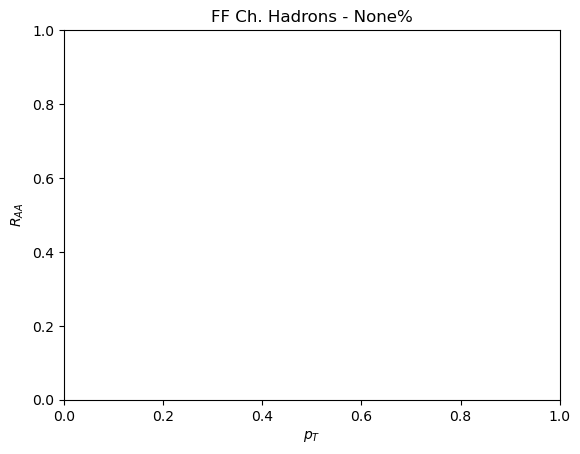

In [58]:
######################
# Centrality Binning #
######################
'''
Binning the data according to multiplicity bins to mimic experimental "centrality".
'''
# New Dataset Bins
mult_bins = mult_bins_b 

def cent(mult):
    if cent_choice == None:
        return True
    
    index = np.where(cent_bins == cent_choice)[0][0]
    min_mult = mult_bins[index]
    max_mult = mult_bins[index+1]
    try:
        mult = float(mult)
    except:
        return False
    if (mult < max_mult) and (mult > min_mult):
        return True
    # elif (mult/100 < max_mult) and (mult/100 > min_mult):
    #     return True
    else:
        return False



print('Computing Average RAA')
fig, axis = plt.subplots()
axis.set_xlabel(r'$p_T$')
axis.set_ylabel(r'$R_{AA}$')
axis.set_title(r'FF Ch. Hadrons - {}%'.format(cent_choice))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
i = 1

# Select bins
save_pt_bins = np.linspace(1, 40, 8)#CMS_pt_bins
bin_centers = (save_pt_bins[:-1] + save_pt_bins[1:]) / 2


# Get the right tag
if cel_bool:
    tag_sel = "f_100_cel"
else:
    tag_sel = "f_100"

# Create RAA dataframe
raa_dict = {}
raa_dict['pt'] = obs[tag_sel].pt
coupling_weights = np.array([])

#coupling_list = coupling_counts.index.to_numpy().astype(np.float64)

for coupling in coupling_list:
    cut_ds = obs[tag_sel].filter_by_attrs(g=coupling, mult=cent)
    # Get weights
    coupling_weights = np.append(coupling_weights, len(cut_ds))
    
    # Compute R_AA
    variable_array = np.array([])
    weight_array = np.array([])
    var_name = "raa"
    variables_with_name = [var for var in cut_ds.variables if var_name in var]
    variables_with_weight = [var for var in cut_ds.variables if 'weight' in var]
    weight_array = cut_ds[variables_with_weight].fillna(0).to_array(dim='new')
    # variable_array = ds[variables_with_name].to_array(dim='new').weighted(weight_array).mean(dim='new', skipna=True)
    variable_array = cut_ds[variables_with_name].to_array(dim='new').mean(dim='new', skipna=True)  # NOTE: Does not use weights!!!
    
    APE_raa_pt_array = cut_ds.pt.to_numpy()
    APE_raa_RAA_array = variable_array
    
    # # Get ALICE R_AA
    # alice_raa_pt_array = RAA_data[RAA_data['cent'] == cent]['pt'].to_numpy()
    # alice_raa_RAA_array = RAA_data[RAA_data['cent'] == cent]['RAA'].to_numpy()
    
    # Plot
    axis.plot(APE_raa_pt_array, APE_raa_RAA_array, label='APE g={}'.format(coupling), color=colors[i])

    # Add to dataframe
    raa_dict[str(coupling)] = APE_raa_RAA_array

    i += 1

axis.set_xscale('log')
# axis.plot(alice_raa_pt_array, alice_raa_RAA_array, label='ALICE {}%'.format(cent), linestyle='--', color=colors[i])


axis.legend()
axis.set_ylim(0, 1.1)

#np.savetxt('30-50_data_log/data_g2.5_jma_pions.csv', np.stack((bin_centers, pion_aa_pp), axis=-1))

# Perform Log Fits & Plot

KeyError: 'pt'

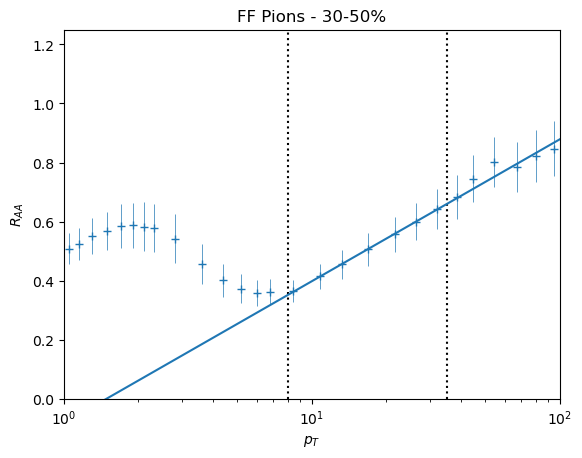

In [18]:
# fig, axis = plt.subplots()
# axis.set_xlabel(r'$p_T$')
# axis.set_ylabel(r'$R_{AA}$')
# axis.set_title(r'FF Pions - {}%'.format(cent_choice))
# axis.axvline(pt_min, ls=':', color='black')
# axis.axvline(pt_max, ls=':', color='black')
# axis.set_xlim(1, 100)
# axis.set_ylim(0, 1.25)
# axis.set_xscale('log')


# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# i = 0

# # Create dataframe to store fits
# fit_df = pd.DataFrame({})

# # Do experimental fit
# # Mask pt
# pt_mask = (CMS_raa_pt_array > pt_min) & (CMS_raa_pt_array < pt_max)

# # Perform the fit on the CMS data
# CMS_0, CMS_1 = np.polyfit(np.log(CMS_raa_pt_array[pt_mask]), CMS_raa_RAA_array[pt_mask], 1, w=1/2*p_err[pt_mask])
# cms_fit = CMS_0 * np.log(CMS_raa_pt_array) + CMS_1

# # Get fit rchi^2
# CMS_rchi2 = np.sum((CMS_raa_RAA_array[pt_mask] - cms_fit[pt_mask])**2/(((2*p_err[pt_mask])**2)*(len(CMS_raa_RAA_array[pt_mask]) - 2)))

# # Add to dataframe
# fit_df = pd.concat(
#     [fit_df, pd.DataFrame({'exp' : [CMS_0, CMS_1, CMS_rchi2]})], axis=1
# )

# # Plot data
# axis.errorbar(CMS_raa_pt_array, CMS_raa_RAA_array, yerr=p_err, ls='None', marker='+', color=colors[i], elinewidth=0.5, label=r'CMS')

# # Plot fit
# axis.plot(CMS_raa_pt_array, cms_fit, color=colors[i])


# i += 1
# # ------------ 

# # Do JMA fits
# for coupling in coupling_list:    
#     # Get RAA
#     jma_pt = raa_dict['pt'].to_numpy()
#     jma_raa = raa_dict[str(coupling)].to_numpy()

#     # Create mask
#     pt_mask = (jma_pt > pt_min) & (jma_pt < pt_max)

#     # Fit
#     JMA_0, JMA_1 = np.polyfit(np.log(jma_pt[pt_mask]), jma_raa[pt_mask], 1)
#     jma_fit = JMA_0 * np.log(jma_pt) + JMA_1

#     # Get fit rchi^2
#     JMA_rchi2 = np.sum((jma_raa[pt_mask] - jma_fit[pt_mask])**2/(len(jma_raa[pt_mask]) - 2))

#     # Add to dataframe
#     fit_df = pd.concat(
#         [fit_df, pd.DataFrame({str(coupling) : [JMA_0, JMA_1, JMA_rchi2]})], axis=1
#     )

#     # Plot data
#     axis.plot(jma_pt, jma_raa, ls='None', marker='+', color=colors[i])
    
#     # Plot fit
#     axis.plot(jma_pt, jma_fit, color=colors[i], label=r'APE g={0:.1f}, $\chi^2/\nu=${1:.5f}'.format(coupling, JMA_rchi2))


#     i += 1


# axis.legend()



# Interpolate Fit Parameters

In [28]:
slope_0*coupling_list

array([0.05719541, 0.06005518])

Slope chosen g = 3.1427391765205264
Intercept chosen g = 2.108551888166103


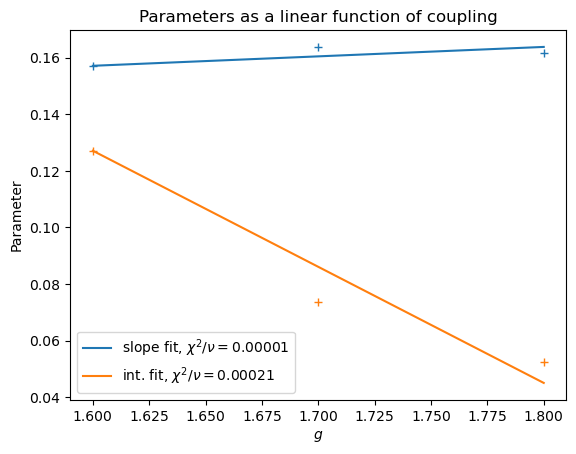

In [43]:
# Create the figure
fig, axis = plt.subplots()
axis.set_xlabel(r'$g$')
axis.set_ylabel('Parameter')
axis.set_title('Parameters as a linear function of coupling')

# Perform fit of slope and intercept
slope_0, slope_1 = np.polyfit(coupling_list, fit_df.iloc[0, 1:], deg=1, w=coupling_weights)
slope_rchi2 = np.sum((fit_df.iloc[0, 1:] - (slope_0 * coupling_list + slope_1))**2/(len(fit_df.iloc[0, 1:]) - 2))

int_0, int_1 = np.polyfit(coupling_list, fit_df.iloc[1, 1:], deg=1, w=coupling_weights)
int_rchi2 = np.sum((fit_df.iloc[1, 1:] - (int_0 * coupling_list + int_1))**2/(len(fit_df.iloc[1, 1:]) - 2))

# Plot 
axis.plot(coupling_list, slope_0 * coupling_list + slope_1, label=r'slope fit, $\chi^2/\nu=${0:.5f}'.format(slope_rchi2), 
          color=colors[0])
axis.plot(coupling_list, fit_df.iloc[0, 1:], ls='None', marker='+', color=colors[0])

axis.plot(coupling_list, int_0 * coupling_list + int_1, label=r'int. fit, $\chi^2/\nu=${0:.5f}'.format(int_rchi2), 
          color=colors[1])
axis.plot(coupling_list, fit_df.iloc[1, 1:], ls='None', marker='+', color=colors[1])
axis.legend()

# Compute target couplings
print('Slope chosen g = {}'.format((CMS_0 - slope_1)/slope_0))
print('Intercept chosen g = {}'.format((CMS_1 - int_1)/int_0))

# Select coupling with reduced $\chi^2$ & Plot

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.04771221843722744
        x: [ 1.827e+00]
      nit: 1
      jac: [ 1.499e-07]
 hess_inv: [[1]]
     nfev: 6
     njev: 3


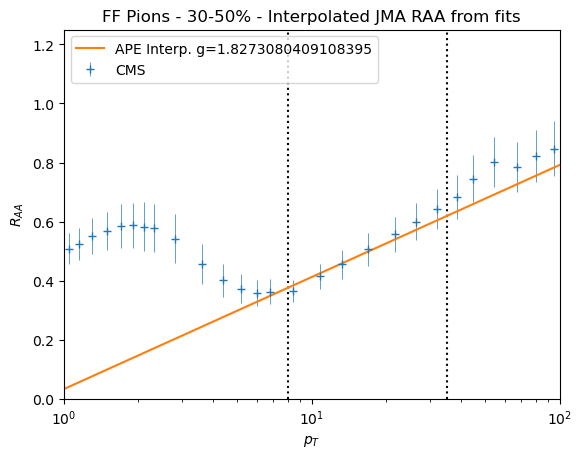

In [44]:
# Define rchi^2 function to be minimized
def g_rchi2(g):
    # Get log fit RAA from interpolation
    a0 = (slope_0 * g + slope_1)
    a1 = (int_0 * g + int_1)
    raa_fit = lambda pt :  a0 * np.log(pt) + a1

    # Compute rchi^2 for selected pt range
    pt_mask = (CMS_raa_pt_array > pt_min) & (CMS_raa_pt_array < pt_max)
    rchi2 = np.sum((CMS_raa_RAA_array[pt_mask] - raa_fit(CMS_raa_pt_array[pt_mask]))**2/((((2*p_err[pt_mask])**2) *(len(CMS_raa_RAA_array[pt_mask]) - 2))))

    return rchi2

# Find g for minimum rchi^2
guess_g = 2
g_optimization = optimize.minimize(fun=g_rchi2, x0=guess_g)
chosen_g = g_optimization.x[0]
print(g_optimization)


# Plot chosen interpolation against data and data fit
fig, axis = plt.subplots()
axis.set_xlabel(r'$p_T$')
axis.set_ylabel(r'$R_{AA}$')
axis.set_title(r'FF Pions - {}% - Interpolated JMA RAA from fits'.format(cent_choice))
axis.axvline(pt_min, ls=':', color='black')
axis.axvline(pt_max, ls=':', color='black')
axis.set_xlim(1, 100)
axis.set_ylim(0, 1.25)
axis.set_xscale('log')

# Plot data
axis.errorbar(CMS_raa_pt_array, CMS_raa_RAA_array, yerr=p_err, ls='None', marker='+', color=colors[0], elinewidth=0.5, label=r'CMS')

# Plot data fit
#axis.plot(CMS_raa_pt_array, cms_fit, color=colors[0])

# Plot JMA interpolation at chosen coupling
chosen_a0 = (slope_0 * chosen_g + slope_1)
chosen_a1 = (int_0 * chosen_g + int_1)
raa_interp_fit = lambda pt :  chosen_a0 * np.log(pt) + chosen_a1
axis.plot(CMS_raa_pt_array, raa_interp_fit(CMS_raa_pt_array), color=colors[1], label='APE Interp. g={}'.format(chosen_g))
axis.legend()